In [2]:
!wget -O "dataset.zip" "https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded"


--2025-06-24 08:48:18--  https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd [following]
--2025-06-24 08:48:18--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 52.92.16.242, 3.5.64.37, 3.5.66.116, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|52.92.16.242|:443... c

In [3]:
!unzip /content/dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (132).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1320).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1321).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1322).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1323).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1324).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1325).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1326).JPG  
  infl

In [4]:
!pip install split-folders

In [5]:
import splitfolders
splitfolders.ratio('/content/Plant_leave_diseases_dataset_with_augmentation',output='dataset',seed=1337,ratio=(.8,0.1,0.1))

Copying files: 61486 files [00:14, 4158.60 files/s]


In [6]:
import tensorflow as tf
train_dir ="/content/dataset/train"
validation_dir = "/content/dataset/val"
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 49179 files belonging to 39 classes.


In [7]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
test_dir = "/content/dataset/test"
test_datset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 6139 files belonging to 39 classes.
Found 6168 files belonging to 39 classes.


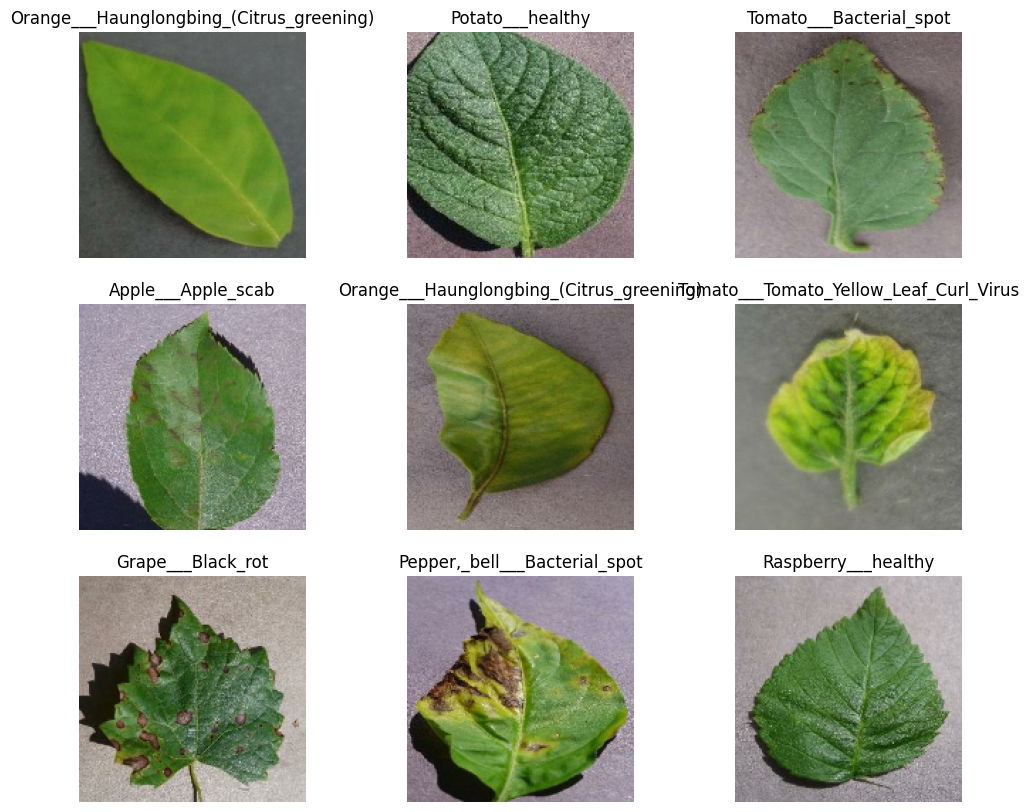

In [8]:
import matplotlib.pyplot as plt
class_names = train_dataset.class_names

plt.figure(figsize=(12, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_datset.prefetch(buffer_size=AUTOTUNE)

In [10]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB4(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1792)


In [13]:
base_model.trainable = False

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1792)


In [15]:
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 39)


In [16]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
len(model.trainable_variables)

2

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseTopKCategoricalAccuracy(name='accuracy')])

In [19]:
initial_epochs = 6

loss0, accuracy0 = model.evaluate(validation_dataset)

192/192 ━━━━━━━━━━━━━━━━━━━━ 30s 86ms/step - accuracy: 0.1246 - loss: 3.7558


In [20]:
print("initial loss:",(loss0))
print("initial accuracy:",(accuracy0))

initial loss: 3.7535901069641113
initial accuracy: 0.12347287684679031


In [21]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 151s 69ms/step - accuracy: 0.9036 - loss: 1.1783 - val_accuracy: 0.9940 - val_loss: 0.3162
Epoch 2/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 108s 60ms/step - accuracy: 0.9937 - loss: 0.3355 - val_accuracy: 0.9963 - val_loss: 0.2285
Epoch 3/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 135s 56ms/step - accuracy: 0.9962 - loss: 0.2572 - val_accuracy: 0.9971 - val_loss: 0.1893
Epoch 4/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 144s 57ms/step - accuracy: 0.9973 - loss: 0.2188 - val_accuracy: 0.9976 - val_loss: 0.1704
Epoch 5/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 142s 57ms/step - accuracy: 0.9978 - loss: 0.1995 - val_accuracy: 0.9974 - val_loss: 0.1571
Epoch 6/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 88s 57ms/step - accuracy: 0.9979 - loss: 0.1840 - val_accuracy: 0.9980 - val_loss: 0.1452


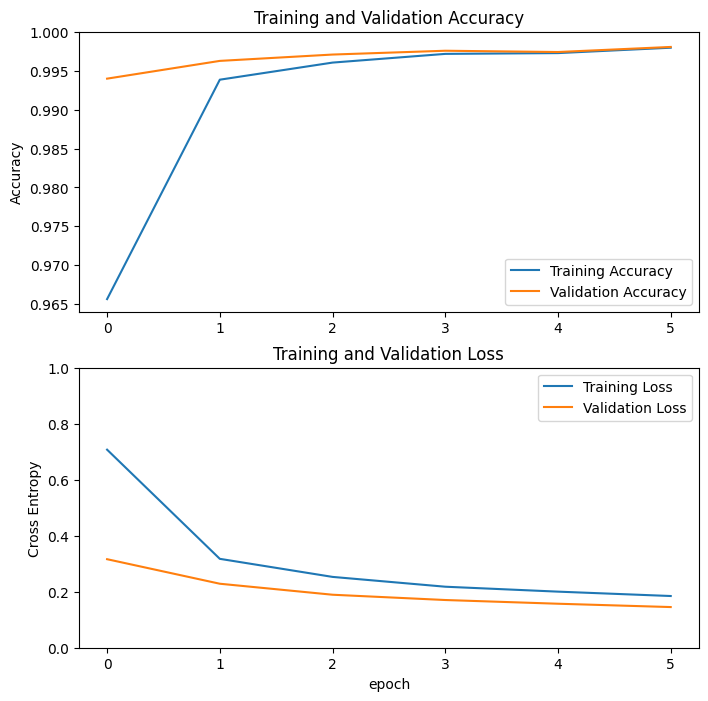

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
base_model.trainable = True

In [24]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  475


In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseTopKCategoricalAccuracy(name='accuracy')])

In [26]:
len(model.trainable_variables)

333

In [27]:
fine_tune_epochs = 1
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 7/7
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 469s 224ms/step - accuracy: 0.9847 - loss: 0.3896 - val_accuracy: 0.9971 - val_loss: 0.0798


In [28]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [29]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

193/193 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.9976 - loss: 0.0963
Test accuracy : 0.9970816969871521


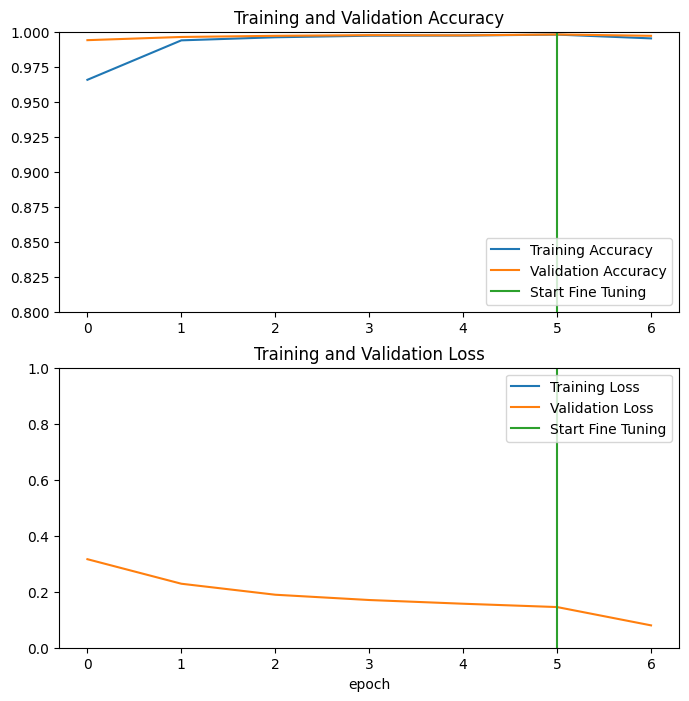

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9975 - loss: 0.0958
Test accuracy : 0.9970816969871521


Predictions:
 [ 3 20 34 33  8 31 34 25  9 28 19 25 38 36 31  5  3 36 10 19 35 23 36 32
 16 18  1 14 37 36 35  8]
Labels:
 [ 3 20 34 33  8 31 34 25  9 28 19 25 38 36 30  5  3 36 10 19 35 23 36 32
 16 18  1 14 37 36 35  8]


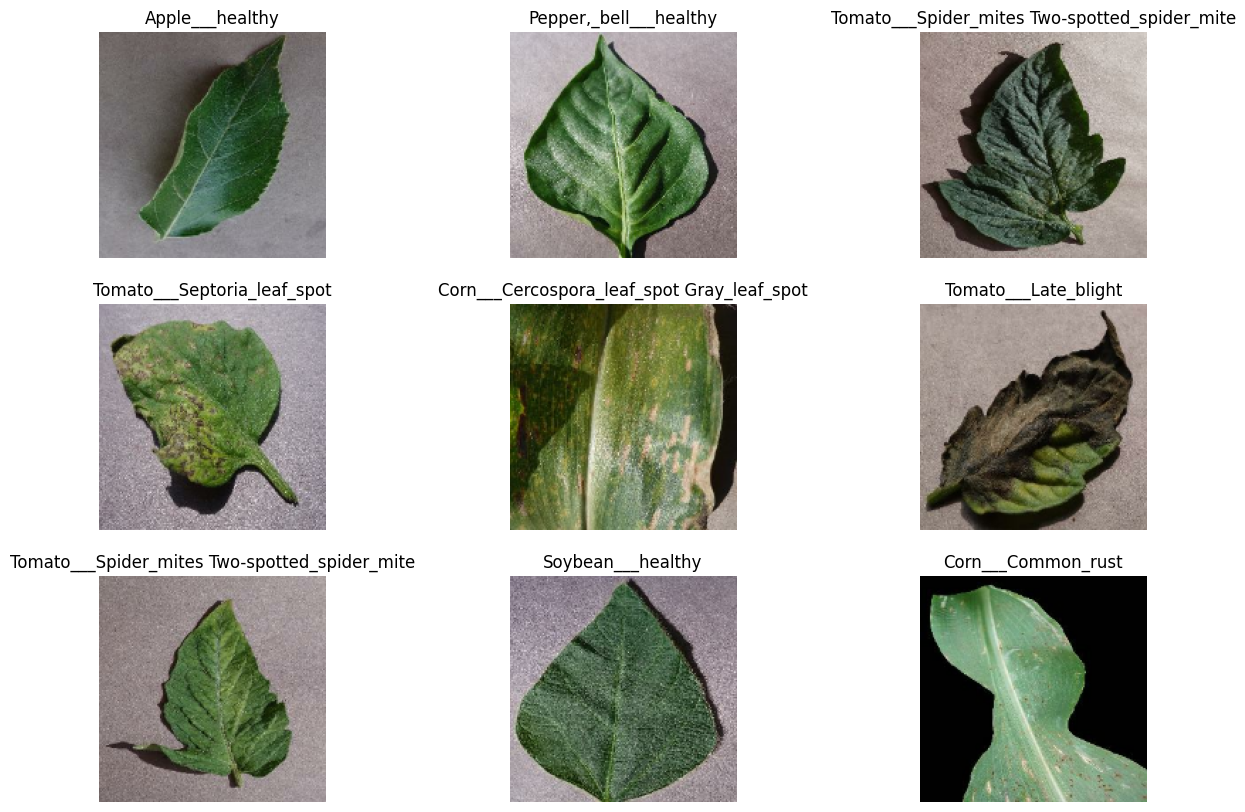

In [32]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.argmax(predictions,axis = 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(15, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [35]:
model.save('plant_disease_model.h5')

In [36]:
model.save('/content/drive/MyDrive/plant_disease_model.h5')